## Data load, transformation and brief analysis before fitting a model

Importing modules, reading and displaying some of the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

In [2]:
data = pd.read_csv('./data/autos.csv', index_col=0)
print("Data has {0} rows and {1} columns".format(data.shape[0], data.shape[1]))
data.head()

Data has 371528 rows and 20 columns


,dateCrawled,name,seller,offerType,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,dateCreated,nrOfPictures,postalCode,lastSeen
index,,,,,,,,,,,,,,,,,,,,
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,480,test,NaN,1993,manuell,0,golf,150000,0,benzin,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,18300,test,coupe,2011,manuell,190,NaN,125000,5,diesel,audi,ja,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,9800,test,suv,2004,automatik,163,grand,125000,8,diesel,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,1500,test,kleinwagen,2001,manuell,75,golf,150000,6,benzin,volkswagen,nein,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,3600,test,kleinwagen,2008,manuell,69,fabia,90000,7,diesel,skoda,nein,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Data columns description

- dateCrawled:	Date the car was crawled. (Date)
- name:	Name of the car. (String)
- seller:	Type of seller (private or dealer). (String)
- offerType:	Type of offer (e.g. sale, repair, etc.). (String)
- price:	Price of the car. (Integer)
- abtest:	Test type (A or B). (String)
- vehicleType:	Type of vehicle (e.g. SUV, sedan, etc.). (String)
- yearOfRegistration:	Year the car was registered. (Integer)
- gearbox:	Type of gearbox (manual or automatic). (String)
- powerPS:	Power of the car in PS. (Integer)
- model:	Model of the car. (String)
- kilometer:	Kilometers the car has been driven. (Integer)
- monthOfRegistration:	Month the car was registered. (Integer)
- fuelType:	Type of fuel (e.g. diesel, petrol, etc.). (String)
- brand:	Brand of the car. (String)
- notRepairedDamage:	Whether or not the car has any damage that has not been repaired. (String)
- dateCreated:	Date the car was created. (Date)
- nrOfPictures:	Number of pictures of the car. (Integer)
- postalCode:	Postal code of the car. (Integer)
- lastSeen:	Date the car was last seen. (Date)

### Data Visualization

Let's start by plotting some relations between car features and prices, aiming to identify linear and non-linear relations.

c:\Users\phara\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


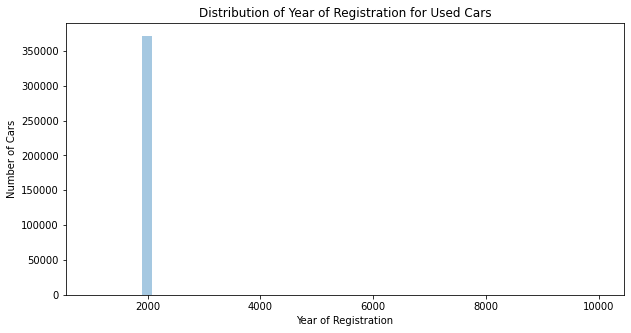

In [3]:
# yearOfRegistration column
plt.figure(figsize=(10,5))
sns.distplot(data['yearOfRegistration'], kde=False)
plt.xlabel('Year of Registration')
plt.ylabel('Number of Cars')
plt.title('Distribution of Year of Registration for Used Cars')
plt.show()

Cleaning data, removing cases where year of registrarion is out of `1900-2023` range and plotting it again

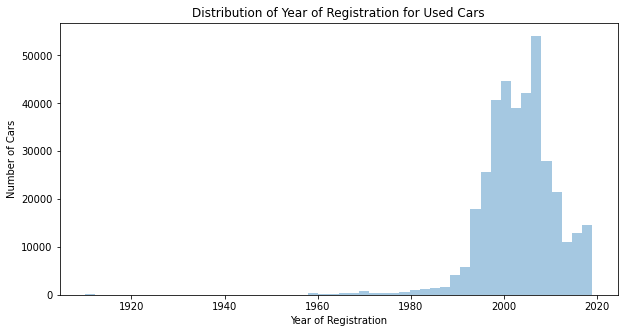

In [4]:
# yearOfRegistration column
data = data[(data['yearOfRegistration'] >= 1900) & (data['yearOfRegistration'] <= 2023)].reset_index(drop=True)
data['yearOfRegistration'] = data['yearOfRegistration'].astype(int)
plt.figure(figsize=(10,5))
sns.distplot(data['yearOfRegistration'], kde=False)
plt.xlabel('Year of Registration')
plt.ylabel('Number of Cars')
plt.title('Distribution of Year of Registration for Used Cars')
plt.show()

To explore `yearOfRegistration - price` let's get the 5 most popular car models in the database and plot these two variables together for each case

Text(0.5, 0, 'Year of Regsitration')

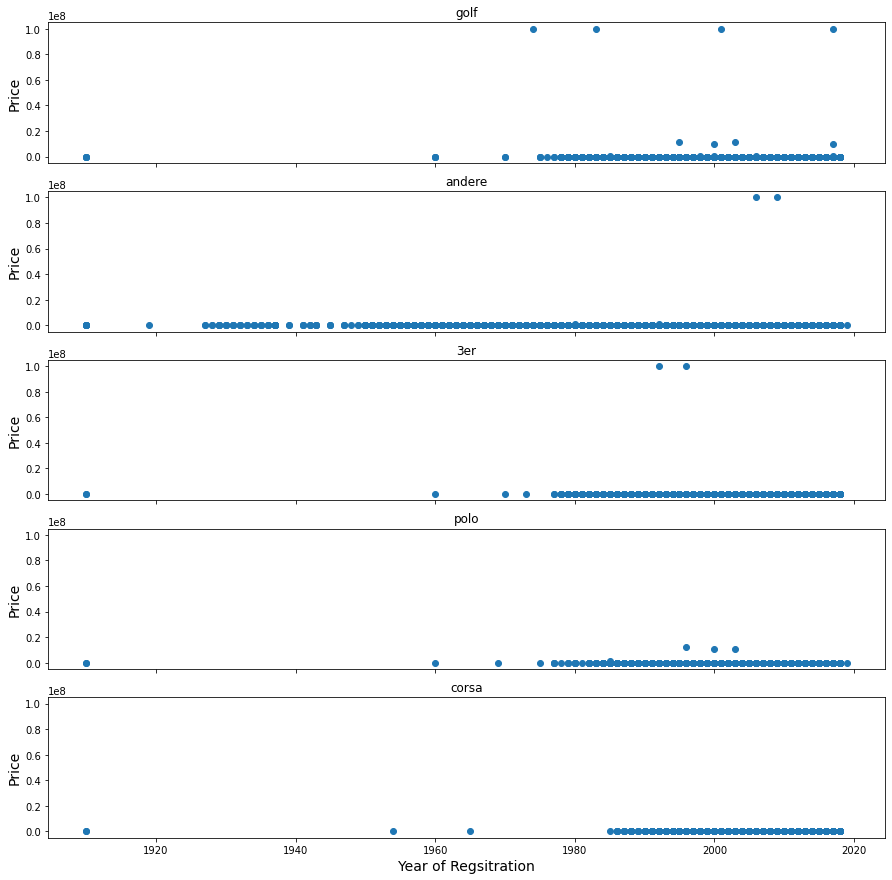

In [5]:
n=5
top_models = data['model'].value_counts().sort_values(ascending=False)[:n].index
fig, axs = plt.subplots(n, sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(n):
    df = data[data['model'] == top_models[i]].reset_index(drop=True)
    axs[i].scatter(df.loc[:, 'yearOfRegistration'], df.loc[:, 'price'])
    axs[i].set_title("{0}".format(top_models[i]))
    axs[i].set_ylabel("Price", size=14)
plt.xlabel("Year of Regsitration", size=14)

This first plot indicates that we also must clean the data based on the price column. Apparently, there are some cars with the wrong price. In order to fix that issue, let's remove the outliers cases. To avoid further similar issues with other numerical columns, we apply the outlier removal for all numeric columns in the data.

In [6]:
def remove_outliers(df: pd.DataFrame) -> pd.DataFrame:
    """
    This function removes outliers from a given dataframe by calculating the lower and upper bounds of the interquartile range (IQR). 
    Outliers are defined as values that are less than Q1 - 1.5 * IQR or greater than Q3 + 1.5 * IQR, where Q1 and Q3 are the first and third quartiles,
    respectively.

    Input:
    df (pd.DataFrame): A dataframe containing numeric columns

    Output:
    df (pd.DataFrame): A dataframe containing only rows that are not considered outliers
    """
    
    Q1 = df.quantile(.1, numeric_only=True) # find the Q1 value for each column with numeric data
    Q3 = df.quantile(.9, numeric_only=True) # find the Q3 value for each column with numeric data
    IQR = Q3 - Q1 # find the interquartile range for each column with numeric data
    
    # return the dataframe with rows that do not have any values lower than Q1 - 1.5 * IQR or higher than Q3 + 1.5 * IQR
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

data = remove_outliers(data)

C:\Users\phara\AppData\Local\Temp\ipykernel_21852\1281583071.py:19: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


Text(0.5, 0, 'Year of Regsitration')

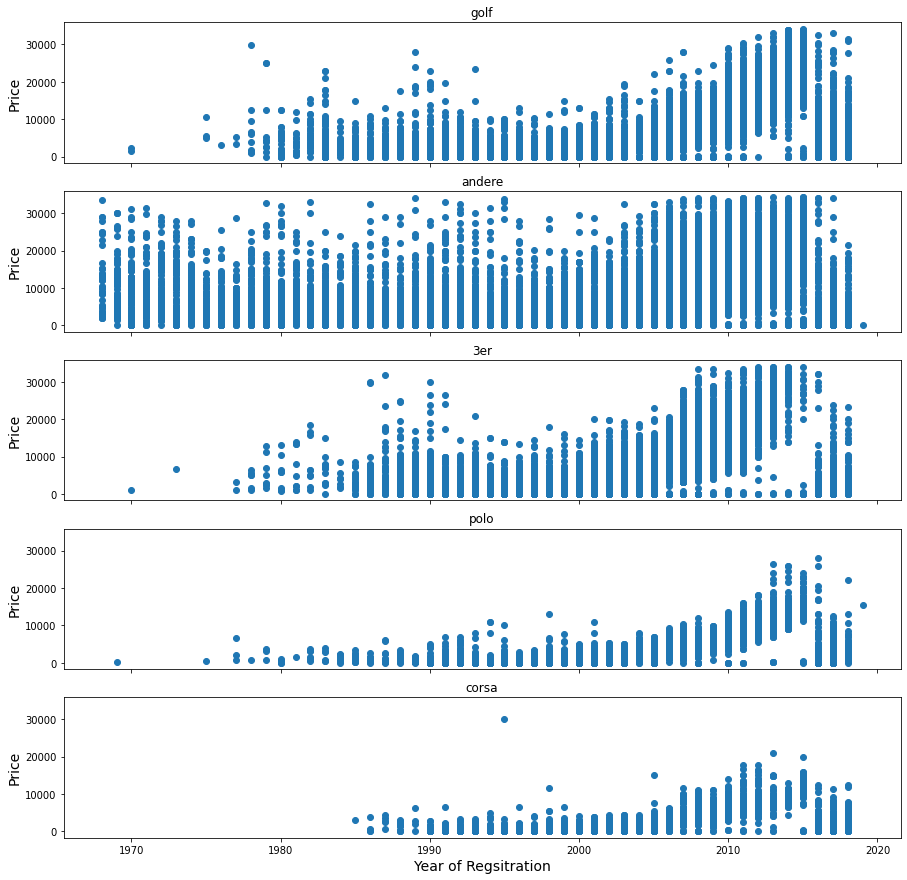

In [7]:
fig, axs = plt.subplots(n, sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(n):
    df = data[data['model'] == top_models[i]].reset_index(drop=True)
    axs[i].scatter(df.loc[:, 'yearOfRegistration'], df.loc[:, 'price'])
    axs[i].set_title("{0}".format(top_models[i]))
    axs[i].set_ylabel("Price", size=14)
plt.xlabel("Year of Regsitration", size=14)

After removing the outliers, the relation between the year of registration and the car prices become more clear. As expected, in general, the newest the car, the higher the price.
Now, let's analyze whether the car's mileage has an impact on the price or not.

Text(0.5, 0, 'Kilometer')

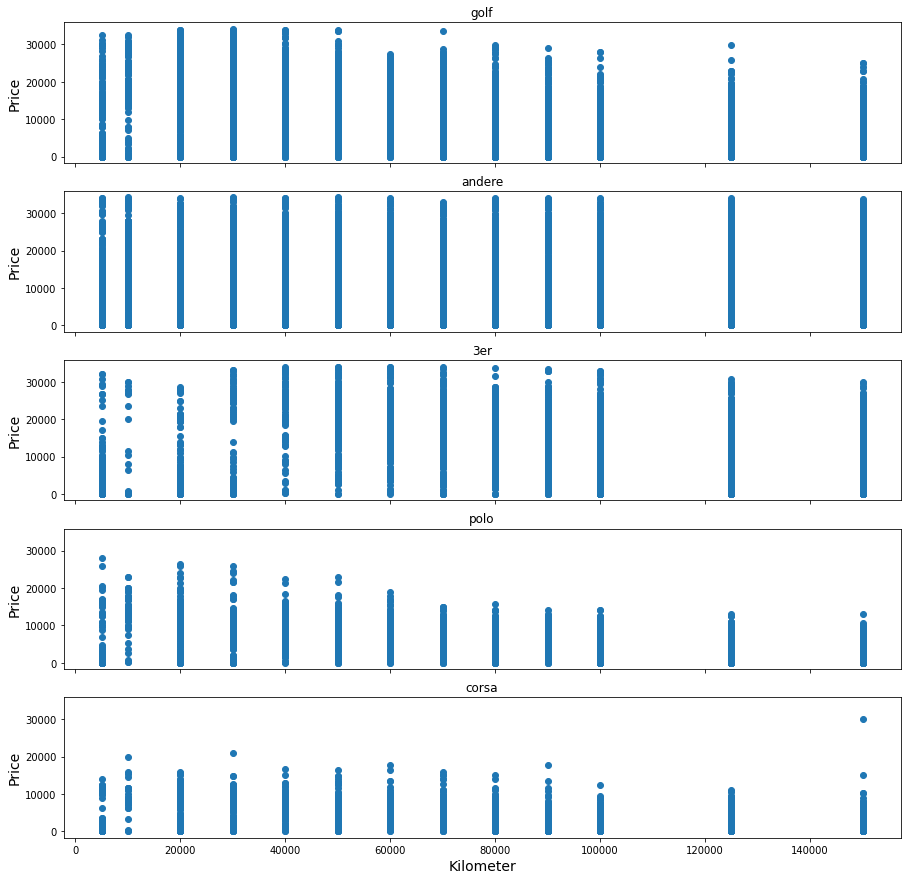

In [8]:
fig, axs = plt.subplots(n, sharex=True, sharey=True)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(n):
    df = data[data['model'] == top_models[i]].reset_index(drop=True)
    axs[i].scatter(df.loc[:, 'kilometer'], df.loc[:, 'price'])
    axs[i].set_title("{0}".format(top_models[i]))
    axs[i].set_ylabel("Price", size=14)
plt.xlabel("Kilometer", size=14)

Again, as expected, the less kilometers a car have, the higher its price. However, we are only plotting these relations for the 5 most popular car models in our dataset. Let's expand our analysis for the entire dataset. 
Next, we plot the correlation matrix for all numerical variables in our dataset after performing all the necessary operations to format the columns.

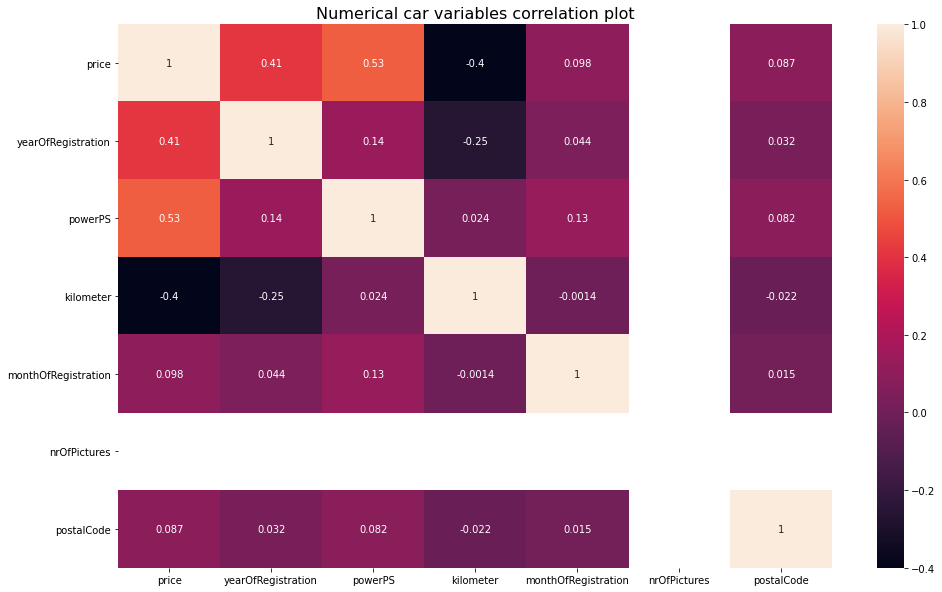

In [9]:
df = data[data.select_dtypes(include=np.number).columns.tolist()]
fig = plt.subplots(figsize=(16, 10))
sns.heatmap(df.corr(), annot=True)
plt.title('Numerical car variables correlation plot', size=16)
plt.show()

Regards the `price` feature, the correlation plots reveals some moderate positive correlations with `yearOfRegistration` and `powerPS` and a moderate negative correlation with the `kilometer` variable.
For the `nrOfPictures`, it seems to be unable to compute the correlation. Let's take a look at this column.

In [10]:
data['nrOfPictures'].value_counts()

0    365154
Name: nrOfPictures, dtype: int64

Since all cases equals to 0, let's remove this column from our dataset.

In [11]:
data = data.drop('nrOfPictures', axis=1)

Now that we've looked into the relations between `price` and every numerical feature, let's explore the significance of each categorical feature for the car's price.

In [12]:
df = data.drop(data.select_dtypes(include=np.number).columns.tolist(), axis=1)
df['price'] = data['price']
df.head()

,dateCrawled,name,seller,offerType,abtest,vehicleType,gearbox,model,fuelType,brand,notRepairedDamage,dateCreated,lastSeen,price
0,2016-03-24 11:52:17,Golf_3_1.6,privat,Angebot,test,NaN,manuell,golf,benzin,volkswagen,NaN,2016-03-24 00:00:00,2016-04-07 03:16:57,480
1,2016-03-24 10:58:45,A5_Sportback_2.7_Tdi,privat,Angebot,test,coupe,manuell,NaN,diesel,audi,ja,2016-03-24 00:00:00,2016-04-07 01:46:50,18300
2,2016-03-14 12:52:21,"Jeep_Grand_Cherokee_""Overland""",privat,Angebot,test,suv,automatik,grand,diesel,jeep,NaN,2016-03-14 00:00:00,2016-04-05 12:47:46,9800
3,2016-03-17 16:54:04,GOLF_4_1_4__3TÜRER,privat,Angebot,test,kleinwagen,manuell,golf,benzin,volkswagen,nein,2016-03-17 00:00:00,2016-03-17 17:40:17,1500
4,2016-03-31 17:25:20,Skoda_Fabia_1.4_TDI_PD_Classic,privat,Angebot,test,kleinwagen,manuell,fabia,diesel,skoda,nein,2016-03-31 00:00:00,2016-04-06 10:17:21,3600


There are three date columns that do not add up to our analysis. 
- First, we drop these columns. We also drop the `name` column, since it's a description of the vehicle, which can lead to several one-to-one relationships and later on, overfit the model. 
- Next, we explore the missing values cases, inputing a string to represent the non-specification of that field by the advertiser.
- As a form of visual analysis, we generated boxplots by categories of each variable to identify different behaviors regarding price.
- Lastly, we run a ANOVA with the categorical features to prove the existence of statistically significant differences for each category.

In [13]:
df = df.drop(['dateCrawled', 'dateCreated', 'lastSeen', 'name'], axis=1)

In [14]:
percentage_of_missing = df.isnull().sum().sort_values(ascending=False) * 100 / len(df)
percentage_of_missing

notRepairedDamage    19.455079
vehicleType          10.217059
fuelType              8.935956
model                 5.350893
gearbox               5.339391
seller                0.000000
offerType             0.000000
abtest                0.000000
brand                 0.000000
price                 0.000000
dtype: float64

This table shows the percentage of missing values in each column of the used car data. The columns are sorted in descending order by the percentage of missing values.
The notRepairedDamage column has the highest percentage of missing values (19.4%), followed by the vehicleType column (10.2%), the fuelType column (9.0%), the model column (5.5%), and the gearbox column (5.4%). These columns have a relatively large number of missing values compared to the other columns.

On the other hand, the brand, abtest, price, offerType, and seller columns have 0% missing values. This means that all values in these columns are present, and there are no missing values.
It is generally important to identify and handle missing values in a dataset, as missing values can affect the accuracy and reliability of analysis and modeling. In some cases, missing values may need to be imputed or estimated, while in other cases they may need to be dropped or replaced with a default value. The appropriate approach depends on the context and purpose of the data analysis.

In [15]:
# adding categorical 'non-specified' string for missing values
for col in df.columns:
    df[col] = np.where(df[col].isna(), 'non-specified', df[col])
percentage_of_missing = df.isnull().sum().sort_values(ascending=False) * 100 / len(df)
percentage_of_missing

seller               0.0
offerType            0.0
abtest               0.0
vehicleType          0.0
gearbox              0.0
model                0.0
fuelType             0.0
brand                0.0
notRepairedDamage    0.0
price                0.0
dtype: float64

In [19]:
for col in df.columns:
    print('COLUMNS {0}'.format(col))
    print(df[col].value_counts())
    print(df[col].value_counts().shape)
    
    print('\n')

COLUMNS seller
privat        365152
gewerblich         2
Name: seller, dtype: int64
(2,)


COLUMNS offerType
Angebot    365142
Gesuch         12
Name: offerType, dtype: int64
(2,)


COLUMNS abtest
test       189173
control    175981
Name: abtest, dtype: int64
(2,)


COLUMNS vehicleType
limousine        94597
kleinwagen       79822
kombi            67020
non-specified    37308
bus              29824
cabrio           21813
coupe            17637
suv              13891
andere            3242
Name: vehicleType, dtype: int64
(9,)


COLUMNS gearbox
manuell          271908
automatik         73749
non-specified     19497
Name: gearbox, dtype: int64
(3,)


COLUMNS model
golf             29979
andere           25003
3er              20476
non-specified    19539
polo             13066
                 ...  
kalina               9
rangerover           6
serie_2              5
serie_3              4
serie_1              2
Name: model, Length: 251, dtype: int64
(251,)


COLUMNS fuelType
benzin      

In [29]:
df['price'] = df['price'].astype(float)

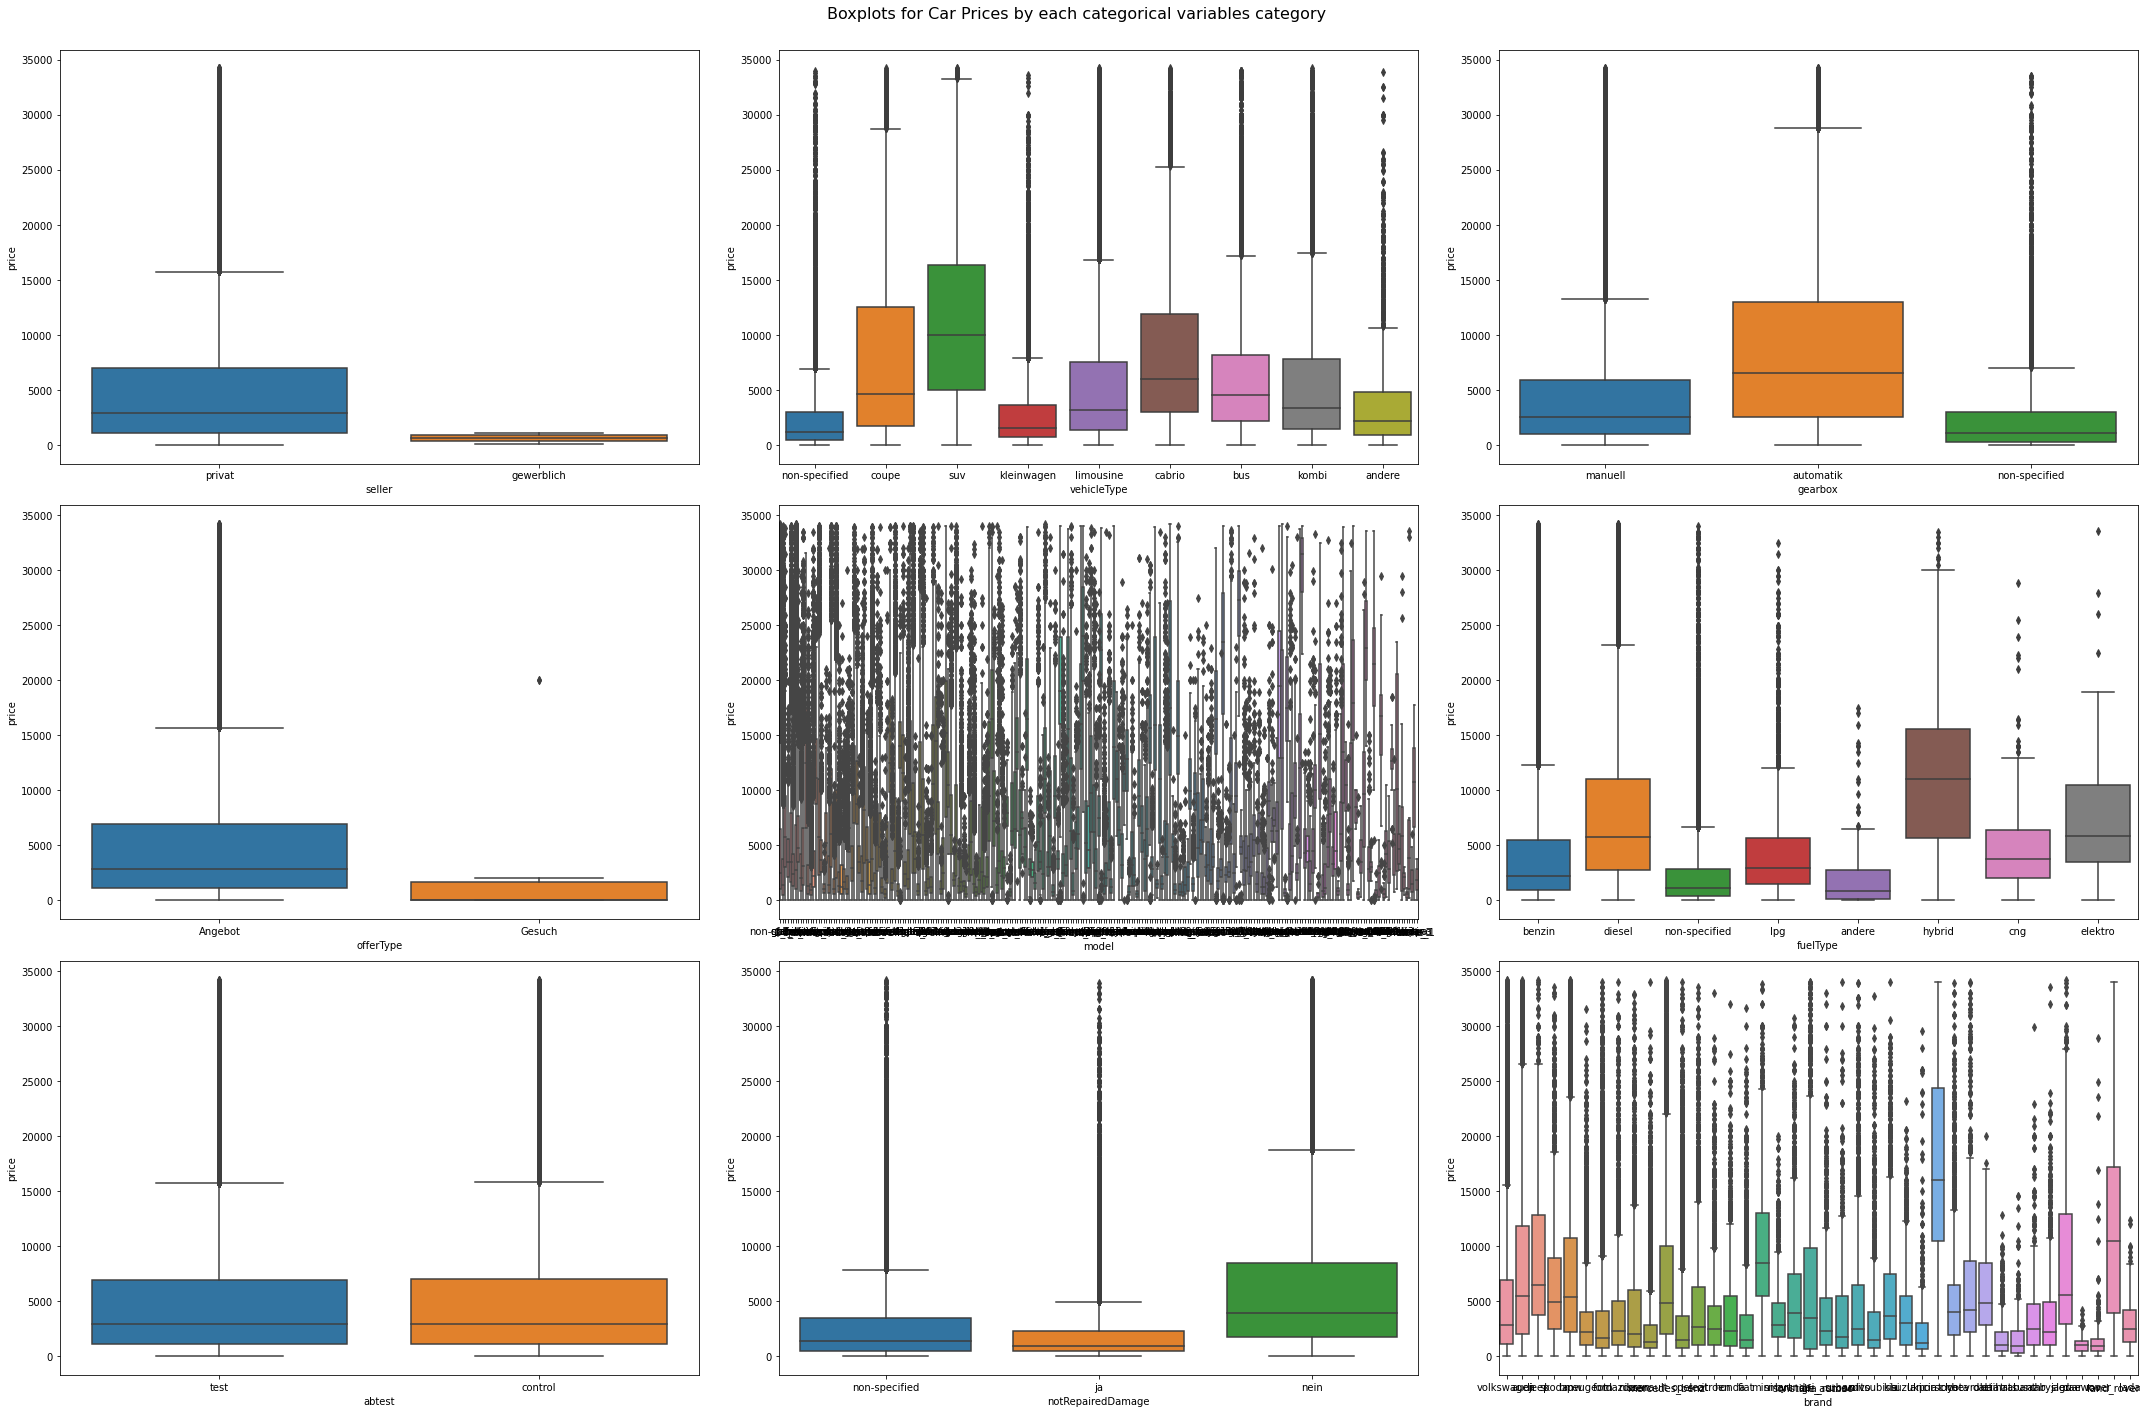

In [44]:
fig, axs = plt.subplots(3,3)
fig.set_figheight(20)
fig.set_figwidth(30)

sns.boxplot(data=df, x='seller', y='price', ax=axs[0,0])

sns.boxplot(data=df, x='offerType', y='price', ax=axs[1,0])

sns.boxplot(data=df, x='abtest', y='price', ax=axs[2,0])

sns.boxplot(data=df, x='vehicleType', y='price', ax=axs[0,1])

sns.boxplot(data=df, x='gearbox', y='price', ax=axs[0,2])

sns.boxplot(data=df, x='model', y='price', ax=axs[1,1])

sns.boxplot(data=df, x='fuelType', y='price', ax=axs[1,2])

sns.boxplot(data=df, x='brand', y='price', ax=axs[2,2])

sns.boxplot(data=df, x='notRepairedDamage', y='price', ax=axs[2,1])

fig.suptitle('Boxplots for Car Prices by each categorical variables category', fontsize=16)
fig.tight_layout()
plt.subplots_adjust(top=0.95)

In [38]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('price ~ seller + offerType + abtest + vehicleType + gearbox + model + fuelType + brand + notRepairedDamage', data=df).fit()

In [39]:
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
seller,4.145826e+06,1.0,0.206238,0.649732
offerType,6.957528e+06,1.0,0.346110,0.556324
abtest,3.776464e+07,1.0,1.878642,0.170489
vehicleType,1.543865e+11,8.0,960.014867,0.000000
gearbox,3.142996e+11,2.0,7817.583209,0.000000
model,1.096122e+12,250.0,218.111020,0.000000
fuelType,2.699064e+11,7.0,1918.111624,0.000000
brand,1.181610e+11,39.0,150.719102,0.000000
notRepairedDamage,3.583453e+11,2.0,8913.131802,0.000000
Residual,7.334089e+12,364842.0,NaN,NaN
